# A Batch Genorator that will give random results


results = pairs ==>> 

last and curr do into the NN

3 point output is recieved

In [5]:
from WritingCSV import loadImage

In [6]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="hand_landmark.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
print('input details : {}'.format(input_details))

output_details = interpreter.get_output_details()
print('output details : {}'.format(output_details))

# Test model on random input data.
input_shape = input_details[0]['shape']


input details : [{'name': 'input_1', 'index': 0, 'shape': array([  1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
output details : [{'name': 'ld_21_2d', 'index': 893, 'shape': array([ 1, 42], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}, {'name': 'output_handflag', 'index': 894, 'shape': array([1, 1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


In [7]:
class Batcher:
    
    def __init__(self): 
        
        self.imageoutputs = []
        self.labels = []
        self.images = []

        imgGen = loadImage('images_all_csv.txt')
        print('loading data')
        for i in range(1200): #why1200?
            if i % 200 == 0:
                print('index : {}'.format(i))

            movs, label, shape, image = next(imgGen)
            #'get the output'
            self.images.append(image)
            input_data = image.reshape(input_shape).astype(np.float32)
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output = interpreter.get_tensor(output_details[0]['index'])
            self.imageoutputs.append(output)
            self.labels.append(np.asarray([label]))

        print ('data loaded')
        
batcher = Batcher()

loading data
index : 0
index : 200
index : 400
index : 600
index : 800
index : 1000
data loaded


In [297]:
def BatchGen_RandomPairs(batchSize, prev_max, imagedata):
    """
    
    Prev_max is the amount of previous frames the picker can choose from for the comparison
    outputsdata in the format [batch[batchlen [curr image, lastimage]], labels[labelslen [currlabel - lastlabel]]]
    
    should learn to output the difference in movement between the two photos
    
    """
    while True:

        batch = np.empty( (batchSize, 1, 84) )
        labels = np.empty( (batchSize, 3) )
        for i in range(batchSize):
            #pick two random indeces -->>
            
            #take a random image and add a preve
            currind = np.random.randint(1000)
            lastind = currind - np.random.randint(prev_max)
            
            
            batch[i] = [np.append(imagedata.imageoutputs[currind], imagedata.imageoutputs[lastind])]
            
            #give the labels for the currind minus the last ind labels to see the degree of change
            labels[i] = np.asarray(imagedata.labels[currind]) - np.asarray(imagedata.labels[lastind])

        
        yield (batch, labels)


In [298]:
def BatchGen_sequential(batchSize, imagedata):
    """
        should output data in the same format as BatchGen_RandomPairs.
        will output images in sequential order, userfull for testing
    """
    
    #where is ind incremented
    ind = 0
    while True:
        try:
            batch = np.asarray([])
            labels = np.asarray([])
            for i in range(batchSize):
                
                #add the inputs for this image and the last to the batch
                batch = np.append(batch, np.asarray( [imagedata.imageoutputs[ind], imagedata.imageoutputs[ind-1]] ))
                
                #give the labels for the currind only
                labels = np.append(labels, np.asarray( [imagedata.labels[ind]] ))
            
            yield np.asarray( [batch, labels] )
        
        except Exception as e:
            print(e)

        #increment and adjust the index
        ind += 1
        if ind + batchSize >= 1200:
            ind = 0

In [299]:
testbatch = BatchGen_sequential(200, batcher)
x = next(testbatch)

In [300]:
testbatch = BatchGen_RandomPairs(2, 1000, batcher)
print(next(testbatch)[0].shape)
print(next(testbatch)[0])

(2, 1, 84)
[[[226.27714539 365.75875854 249.39872742 280.92221069 236.88459778
   280.56854248 186.35032654 232.0715332  172.20851135 247.70933533
   220.96054077 227.03186035 229.71112061 193.38485718 200.28967285
   177.77932739 175.90802002 119.14926147 225.23013306 205.46812439
   233.96755981 156.72370911 205.10301208 148.48907471 198.15135193
   120.32981873 236.48779297 218.25143433 243.90681458 178.29222107
   227.8401947  192.7250061  261.77554321 164.76173401 259.81280518
   264.70803833 218.45892334 234.83277893 194.37454224 247.23667908
   248.92205811 229.61347961 249.57745361 445.21487427 282.71463013
   337.59921265 310.2666626  346.85806274 276.56539917 284.54785156
   250.00799561 287.22607422 278.30255127 252.86808777 282.95111084
   233.75422668 282.31149292 228.29267883 279.83508301 150.35003662
   279.12799072 242.14918518 302.47396851 177.95735168 282.94424438
   188.09059143 257.90966797 170.87901306 272.81665039 261.68936157
   294.7829895  187.05441284 297.9622

# define a model to use

In [315]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D 	
from keras.utils import np_utils

model = Sequential()

#creating the layers, 
model.add(Dense(84, input_shape=(1, 84), kernel_initializer='normal', activation='relu'))
model.add(Dense(42, kernel_initializer='normal'))
model.add(Flatten())
model.add(Dense(21, kernel_initializer='normal'))
model.add(Dense(126))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer='normal'))


#the output
model.add(Dense(3, activation = 'sigmoid', kernel_initializer='normal'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [316]:
H = model.fit_generator(BatchGen_RandomPairs(128, 100, batcher), 300, epochs=5000, verbose=1)

Epoch 1/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1654 - accuracy: 0.3454
Epoch 2/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3347
Epoch 3/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3237
Epoch 4/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3161
Epoch 5/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3227
Epoch 6/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3170
Epoch 7/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1648 - accuracy: 0.3194
Epoch 8/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3129
Epoch 9/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3169
Epoch 10/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.164

300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3320
Epoch 81/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3301
Epoch 82/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3319
Epoch 83/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3301
Epoch 84/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3320
Epoch 85/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1648 - accuracy: 0.3284
Epoch 86/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3343
Epoch 87/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3312
Epoch 88/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3317
Epoch 89/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1660 - a

300/300 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.3286
Epoch 160/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3299
Epoch 161/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3312
Epoch 162/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1651 - accuracy: 0.3292
Epoch 163/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1659 - accuracy: 0.3333
Epoch 164/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.3306
Epoch 165/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3285
Epoch 166/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3313
Epoch 167/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3302
Epoch 168/5000
300/300 [==============================] - 1s 3ms/step - loss: 0

300/300 [==============================] - 1s 3ms/step - loss: 0.1656 - accuracy: 0.3317
Epoch 238/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3340
Epoch 239/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3302
Epoch 240/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3321
Epoch 241/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3314
Epoch 242/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3307
Epoch 243/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3308
Epoch 244/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3344
Epoch 245/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3376
Epoch 246/5000
300/300 [==============================] - 1s 3ms/step - loss: 0

300/300 [==============================] - 1s 3ms/step - loss: 0.1654 - accuracy: 0.3329
Epoch 316/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3295
Epoch 317/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1650 - accuracy: 0.3341
Epoch 318/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1648 - accuracy: 0.3304
Epoch 319/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.3302
Epoch 320/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3268
Epoch 321/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1648 - accuracy: 0.3352
Epoch 322/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3355
Epoch 323/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3334
Epoch 324/5000
300/300 [==============================] - 1s 3ms/step - loss: 0

300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3316
Epoch 394/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1618 - accuracy: 0.3373
Epoch 395/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3297
Epoch 396/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3305
Epoch 397/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3324
Epoch 398/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3317
Epoch 399/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3326
Epoch 400/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3336
Epoch 401/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3323
Epoch 402/5000
300/300 [==============================] - 1s 3ms/step - loss: 0

300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3311
Epoch 472/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3310
Epoch 473/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3289
Epoch 474/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3397
Epoch 475/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3312
Epoch 476/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1624 - accuracy: 0.3318
Epoch 477/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1652 - accuracy: 0.3319
Epoch 478/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3305
Epoch 479/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.3346
Epoch 480/5000
300/300 [==============================] - 1s 3ms/step - loss: 0

300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3324
Epoch 550/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3362
Epoch 551/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3301
Epoch 552/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3324
Epoch 553/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3326
Epoch 554/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1620 - accuracy: 0.3363
Epoch 555/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3317
Epoch 556/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1648 - accuracy: 0.3324
Epoch 557/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1625 - accuracy: 0.3324
Epoch 558/5000
300/300 [==============================] - 1s 3ms/step - loss: 0

300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3321
Epoch 628/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3307
Epoch 629/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3302
Epoch 630/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1652 - accuracy: 0.3266
Epoch 631/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3331
Epoch 632/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1657 - accuracy: 0.3309
Epoch 633/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3311
Epoch 634/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3283
Epoch 635/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3296
Epoch 636/5000
300/300 [==============================] - 1s 3ms/step - loss: 0

300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3355
Epoch 706/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.3340
Epoch 707/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1658 - accuracy: 0.3373
Epoch 708/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3287
Epoch 709/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3355
Epoch 710/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3334
Epoch 711/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3351
Epoch 712/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3327
Epoch 713/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3312
Epoch 714/5000
300/300 [==============================] - 1s 3ms/step - loss: 0

300/300 [==============================] - 1s 3ms/step - loss: 0.1649 - accuracy: 0.3301
Epoch 784/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3337
Epoch 785/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3283
Epoch 786/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1635 - accuracy: 0.3310
Epoch 787/5000
300/300 [==============================] - 1s 2ms/step - loss: 0.1634 - accuracy: 0.3308
Epoch 788/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3290
Epoch 789/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3321
Epoch 790/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3334
Epoch 791/5000
300/300 [==============================] - 2s 7ms/step - loss: 0.1636 - accuracy: 0.3342
Epoch 792/5000
300/300 [==============================] - 5s 15ms/step - loss: 

300/300 [==============================] - 1s 3ms/step - loss: 0.1627 - accuracy: 0.3334
Epoch 862/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3356
Epoch 863/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3285
Epoch 864/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3349
Epoch 865/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3324
Epoch 866/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3323
Epoch 867/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3314
Epoch 868/5000
300/300 [==============================] - 4s 13ms/step - loss: 0.1637 - accuracy: 0.3300
Epoch 869/5000
300/300 [==============================] - 4s 14ms/step - loss: 0.1633 - accuracy: 0.3330
Epoch 870/5000
300/300 [==============================] - 4s 15ms/step - loss

300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3356
Epoch 940/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1650 - accuracy: 0.3341
Epoch 941/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1650 - accuracy: 0.3358
Epoch 942/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3354
Epoch 943/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3317
Epoch 944/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3317
Epoch 945/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.3340
Epoch 946/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3315
Epoch 947/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3294
Epoch 948/5000
300/300 [==============================] - 1s 3ms/step - loss: 0

300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3310
Epoch 1018/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3322
Epoch 1019/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3334
Epoch 1020/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3309
Epoch 1021/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1651 - accuracy: 0.3313
Epoch 1022/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3302
Epoch 1023/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3313
Epoch 1024/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3345
Epoch 1025/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3352
Epoch 1026/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3317
Epoch 1096/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3305
Epoch 1097/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3317
Epoch 1098/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3343
Epoch 1099/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3347
Epoch 1100/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1625 - accuracy: 0.3328
Epoch 1101/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1623 - accuracy: 0.3285
Epoch 1102/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3357
Epoch 1103/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1627 - accuracy: 0.3307
Epoch 1104/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3279
Epoch 1174/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1654 - accuracy: 0.3306
Epoch 1175/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3275
Epoch 1176/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3297
Epoch 1177/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3281
Epoch 1178/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3299
Epoch 1179/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.3315
Epoch 1180/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3336
Epoch 1181/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3338
Epoch 1182/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3322
Epoch 1252/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.3335
Epoch 1253/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3317
Epoch 1254/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3310
Epoch 1255/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3367
Epoch 1256/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3345
Epoch 1257/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3276
Epoch 1258/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3321
Epoch 1259/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3308
Epoch 1260/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3311
Epoch 1330/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1626 - accuracy: 0.3320
Epoch 1331/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.3308
Epoch 1332/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3322
Epoch 1333/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1624 - accuracy: 0.3365
Epoch 1334/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3299
Epoch 1335/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1627 - accuracy: 0.3323
Epoch 1336/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3334
Epoch 1337/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1625 - accuracy: 0.3357
Epoch 1338/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3292
Epoch 1408/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1653 - accuracy: 0.3287
Epoch 1409/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3307
Epoch 1410/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3345
Epoch 1411/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3347
Epoch 1412/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.3323
Epoch 1413/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3353
Epoch 1414/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1654 - accuracy: 0.3301
Epoch 1415/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3321
Epoch 1416/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3316
Epoch 1486/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3305: 0s - loss: 0.1641 - accuracy: 0.33
Epoch 1487/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3343
Epoch 1488/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3311
Epoch 1489/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3323
Epoch 1490/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1652 - accuracy: 0.3332
Epoch 1491/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3330
Epoch 1492/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3319
Epoch 1493/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1648 - accuracy: 0.3324
Epoch 1494/5000
300/300 [==========

300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3302
Epoch 1563/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3322
Epoch 1564/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3341
Epoch 1565/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3317
Epoch 1566/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.3339
Epoch 1567/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3278
Epoch 1568/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3335
Epoch 1569/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3311
Epoch 1570/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1625 - accuracy: 0.3330
Epoch 1571/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3320
Epoch 1641/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3310
Epoch 1642/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3357
Epoch 1643/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3344
Epoch 1644/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3288
Epoch 1645/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3327
Epoch 1646/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1627 - accuracy: 0.3355
Epoch 1647/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1625 - accuracy: 0.3302
Epoch 1648/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3362
Epoch 1649/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 4ms/step - loss: 0.1638 - accuracy: 0.3337
Epoch 1719/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3316
Epoch 1720/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3323
Epoch 1721/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3316
Epoch 1722/5000
300/300 [==============================] - 3s 10ms/step - loss: 0.1633 - accuracy: 0.3267
Epoch 1723/5000
300/300 [==============================] - 5s 15ms/step - loss: 0.1650 - accuracy: 0.3346
Epoch 1724/5000
300/300 [==============================] - 5s 17ms/step - loss: 0.1645 - accuracy: 0.3331
Epoch 1725/5000
300/300 [==============================] - 4s 14ms/step - loss: 0.1645 - accuracy: 0.3337
Epoch 1726/5000
300/300 [==============================] - 4s 14ms/step - loss: 0.1635 - accuracy: 0.3313
Epoch 1727/5000
300/300 [==============================] - 5s 15ms

300/300 [==============================] - 1s 3ms/step - loss: 0.1619 - accuracy: 0.3340
Epoch 1795/5000
300/300 [==============================] - 0s 1ms/step - loss: 0.1637 - accuracy: 0.3301
Epoch 1796/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3345
Epoch 1797/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1644 - accuracy: 0.3268
Epoch 1798/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1626 - accuracy: 0.3325
Epoch 1799/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3317
Epoch 1800/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3257
Epoch 1801/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1626 - accuracy: 0.3331
Epoch 1802/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3339
Epoch 1803/5000
300/300 [==============================] - 4s 14ms/step

300/300 [==============================] - 4s 14ms/step - loss: 0.1641 - accuracy: 0.3301
Epoch 1871/5000
300/300 [==============================] - 4s 14ms/step - loss: 0.1641 - accuracy: 0.3278
Epoch 1872/5000
300/300 [==============================] - 4s 15ms/step - loss: 0.1637 - accuracy: 0.3298
Epoch 1873/5000
300/300 [==============================] - 7204s 24s/step - loss: 0.1632 - accuracy: 0.3298
Epoch 1874/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3325
Epoch 1875/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3303
Epoch 1876/5000
300/300 [==============================] - 0s 1ms/step - loss: 0.1639 - accuracy: 0.3315
Epoch 1877/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3311
Epoch 1878/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1636 - accuracy: 0.3285
Epoch 1879/5000
300/300 [==============================] - 1s 3ms

300/300 [==============================] - 5s 17ms/step - loss: 0.1637 - accuracy: 0.3338
Epoch 1947/5000
300/300 [==============================] - 4s 14ms/step - loss: 0.1637 - accuracy: 0.3310
Epoch 1948/5000
300/300 [==============================] - 4s 15ms/step - loss: 0.1626 - accuracy: 0.3293
Epoch 1949/5000
300/300 [==============================] - 4s 14ms/step - loss: 0.1630 - accuracy: 0.3339
Epoch 1950/5000
300/300 [==============================] - 4s 14ms/step - loss: 0.1642 - accuracy: 0.3304
Epoch 1951/5000
300/300 [==============================] - 4s 14ms/step - loss: 0.1633 - accuracy: 0.3292
Epoch 1952/5000
300/300 [==============================] - 4s 15ms/step - loss: 0.1651 - accuracy: 0.3337
Epoch 1953/5000
300/300 [==============================] - 7203s 24s/step - loss: 0.1629 - accuracy: 0.3297
Epoch 1954/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3355
Epoch 1955/5000
300/300 [==============================] - 1s

300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3307
Epoch 2023/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3326
Epoch 2024/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3307
Epoch 2025/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3287
Epoch 2026/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3289
Epoch 2027/5000
300/300 [==============================] - 1s 2ms/step - loss: 0.1631 - accuracy: 0.3318
Epoch 2028/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3337
Epoch 2029/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3334
Epoch 2030/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3336
Epoch 2031/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3311
Epoch 2101/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3288
Epoch 2102/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3324
Epoch 2103/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3241
Epoch 2104/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3323
Epoch 2105/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1619 - accuracy: 0.3295
Epoch 2106/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3311
Epoch 2107/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1653 - accuracy: 0.3291
Epoch 2108/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3376
Epoch 2109/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3251
Epoch 2179/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3315
Epoch 2180/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3354
Epoch 2181/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3347
Epoch 2182/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3310
Epoch 2183/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1625 - accuracy: 0.3350
Epoch 2184/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3319
Epoch 2185/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1650 - accuracy: 0.3311
Epoch 2186/5000
300/300 [==============================] - 46s 152ms/step - loss: 0.1646 - accuracy: 0.3320
Epoch 2187/5000
300/300 [==============================] - 1s 3ms/st

300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3289
Epoch 2257/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3359
Epoch 2258/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3344
Epoch 2259/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1653 - accuracy: 0.3322
Epoch 2260/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3332
Epoch 2261/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3333
Epoch 2262/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1653 - accuracy: 0.3323
Epoch 2263/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3347
Epoch 2264/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3271
Epoch 2265/5000
300/300 [==============================] - 2s 7ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3329
Epoch 2335/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3314
Epoch 2336/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3324
Epoch 2337/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3290
Epoch 2338/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3339
Epoch 2339/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1618 - accuracy: 0.3325
Epoch 2340/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3305
Epoch 2341/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3339
Epoch 2342/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3332
Epoch 2343/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3283
Epoch 2413/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1627 - accuracy: 0.3291
Epoch 2414/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3326
Epoch 2415/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1656 - accuracy: 0.3300
Epoch 2416/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3395
Epoch 2417/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3297
Epoch 2418/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3313
Epoch 2419/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3328
Epoch 2420/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3321
Epoch 2421/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3343
Epoch 2491/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3307
Epoch 2492/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.3352
Epoch 2493/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3315
Epoch 2494/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3315
Epoch 2495/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3268
Epoch 2496/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3324
Epoch 2497/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3328
Epoch 2498/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.3304
Epoch 2499/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3314
Epoch 2569/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3317
Epoch 2570/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3323
Epoch 2571/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1640 - accuracy: 0.3326
Epoch 2572/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3293
Epoch 2573/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1623 - accuracy: 0.3314
Epoch 2574/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3376
Epoch 2575/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3295
Epoch 2576/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3308
Epoch 2577/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3313
Epoch 2646/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3315
Epoch 2647/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3323
Epoch 2648/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3227
Epoch 2649/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3312
Epoch 2650/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3297
Epoch 2651/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1613 - accuracy: 0.3328
Epoch 2652/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3359
Epoch 2653/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3342
Epoch 2654/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3325
Epoch 2724/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3330
Epoch 2725/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3326
Epoch 2726/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3325
Epoch 2727/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3292
Epoch 2728/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3348
Epoch 2729/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3365
Epoch 2730/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3301
Epoch 2731/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1640 - accuracy: 0.3354
Epoch 2732/5000
300/300 [==============================] - 1s 4ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3299
Epoch 2802/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3318
Epoch 2803/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3337
Epoch 2804/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3313
Epoch 2805/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3309
Epoch 2806/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3319
Epoch 2807/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1620 - accuracy: 0.3324
Epoch 2808/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3376
Epoch 2809/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1650 - accuracy: 0.3332
Epoch 2810/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3315
Epoch 2880/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3346
Epoch 2881/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3332
Epoch 2882/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1623 - accuracy: 0.3291
Epoch 2883/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3321
Epoch 2884/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3324
Epoch 2885/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3324
Epoch 2886/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3332
Epoch 2887/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3309
Epoch 2888/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3310
Epoch 2958/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3317
Epoch 2959/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1653 - accuracy: 0.3334
Epoch 2960/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3312
Epoch 2961/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3309
Epoch 2962/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3306
Epoch 2963/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3341
Epoch 2964/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3277
Epoch 2965/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3342
Epoch 2966/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 2s 6ms/step - loss: 0.1635 - accuracy: 0.3315
Epoch 3036/5000
300/300 [==============================] - 2s 5ms/step - loss: 0.1632 - accuracy: 0.3348
Epoch 3037/5000
300/300 [==============================] - 2s 5ms/step - loss: 0.1642 - accuracy: 0.3304
Epoch 3038/5000
300/300 [==============================] - 2s 5ms/step - loss: 0.1643 - accuracy: 0.3334
Epoch 3039/5000
300/300 [==============================] - 1s 5ms/step - loss: 0.1641 - accuracy: 0.3342
Epoch 3040/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1636 - accuracy: 0.3335
Epoch 3041/5000
300/300 [==============================] - 1s 5ms/step - loss: 0.1624 - accuracy: 0.3311
Epoch 3042/5000
300/300 [==============================] - 2s 7ms/step - loss: 0.1640 - accuracy: 0.3339
Epoch 3043/5000
300/300 [==============================] - 2s 6ms/step - loss: 0.1635 - accuracy: 0.3319
Epoch 3044/5000
300/300 [==============================] - 1s 5ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3345
Epoch 3113/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3316
Epoch 3114/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1651 - accuracy: 0.3341
Epoch 3115/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3314
Epoch 3116/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3316
Epoch 3117/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3316
Epoch 3118/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3328
Epoch 3119/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3277
Epoch 3120/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3335
Epoch 3121/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3347
Epoch 3191/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3325
Epoch 3192/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1650 - accuracy: 0.3311
Epoch 3193/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3288
Epoch 3194/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3320
Epoch 3195/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3304
Epoch 3196/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1650 - accuracy: 0.3286
Epoch 3197/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3334
Epoch 3198/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3337
Epoch 3199/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3288
Epoch 3269/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3305
Epoch 3270/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3343: 0s
Epoch 3271/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3290
Epoch 3272/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3298
Epoch 3273/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3312
Epoch 3274/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1624 - accuracy: 0.3279
Epoch 3275/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.3298
Epoch 3276/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3314
Epoch 3277/5000
300/300 [==============================] - 1s 3ms/s

300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3371
Epoch 3346/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3340
Epoch 3347/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3326
Epoch 3348/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3319
Epoch 3349/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3321
Epoch 3350/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3281
Epoch 3351/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3289
Epoch 3352/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3323
Epoch 3353/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3293
Epoch 3354/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1622 - accuracy: 0.3293
Epoch 3424/5000
300/300 [==============================] - 1s 5ms/step - loss: 0.1624 - accuracy: 0.3315
Epoch 3425/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1627 - accuracy: 0.3322
Epoch 3426/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1633 - accuracy: 0.3364
Epoch 3427/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1628 - accuracy: 0.3307
Epoch 3428/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3273
Epoch 3429/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.3302
Epoch 3430/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3363
Epoch 3431/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3322
Epoch 3432/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3309
Epoch 3501/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1626 - accuracy: 0.3356
Epoch 3502/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3331
Epoch 3503/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3367
Epoch 3504/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3358
Epoch 3505/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3293
Epoch 3506/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3341
Epoch 3507/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1648 - accuracy: 0.3315
Epoch 3508/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3291
Epoch 3509/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3312
Epoch 3579/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3327
Epoch 3580/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.3300
Epoch 3581/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3344
Epoch 3582/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1622 - accuracy: 0.3307
Epoch 3583/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3308
Epoch 3584/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3292
Epoch 3585/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1625 - accuracy: 0.3326
Epoch 3586/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1653 - accuracy: 0.3325
Epoch 3587/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3343
Epoch 3657/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3324
Epoch 3658/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3341
Epoch 3659/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3354
Epoch 3660/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3262
Epoch 3661/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3311
Epoch 3662/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3358
Epoch 3663/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3330
Epoch 3664/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3334
Epoch 3665/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3302
Epoch 3734/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3326
Epoch 3735/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3311
Epoch 3736/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3314
Epoch 3737/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1629 - accuracy: 0.3326
Epoch 3738/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3291
Epoch 3739/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3292
Epoch 3740/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3375
Epoch 3741/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3325
Epoch 3742/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3361
Epoch 3811/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1648 - accuracy: 0.3315
Epoch 3812/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3309
Epoch 3813/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3335
Epoch 3814/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3345
Epoch 3815/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3314
Epoch 3816/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3282
Epoch 3817/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3311
Epoch 3818/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3347
Epoch 3819/5000
300/300 [==============================] - 1s 4ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3312
Epoch 3888/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1651 - accuracy: 0.3308
Epoch 3889/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3338
Epoch 3890/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3339
Epoch 3891/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3323
Epoch 3892/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3343
Epoch 3893/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3295
Epoch 3894/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1656 - accuracy: 0.3374
Epoch 3895/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3327
Epoch 3896/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3293
Epoch 3965/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3357
Epoch 3966/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3312
Epoch 3967/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3317
Epoch 3968/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3321
Epoch 3969/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3314
Epoch 3970/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3277
Epoch 3971/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3304
Epoch 3972/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1649 - accuracy: 0.3269
Epoch 3973/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 4ms/step - loss: 0.1643 - accuracy: 0.3346
Epoch 4042/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3306
Epoch 4043/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1645 - accuracy: 0.3323
Epoch 4044/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3321
Epoch 4045/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1628 - accuracy: 0.3353
Epoch 4046/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3308
Epoch 4047/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3323
Epoch 4048/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3320
Epoch 4049/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1626 - accuracy: 0.3291
Epoch 4050/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 4ms/step - loss: 0.1642 - accuracy: 0.3355
Epoch 4120/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3270
Epoch 4121/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3327
Epoch 4122/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.3293
Epoch 4123/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1647 - accuracy: 0.3319
Epoch 4124/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.3293
Epoch 4125/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3321
Epoch 4126/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3308
Epoch 4127/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3284
Epoch 4128/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3323
Epoch 4198/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3363
Epoch 4199/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1655 - accuracy: 0.3336
Epoch 4200/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1637 - accuracy: 0.3315
Epoch 4201/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.3315
Epoch 4202/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1626 - accuracy: 0.3315
Epoch 4203/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3335
Epoch 4204/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3290
Epoch 4205/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3311
Epoch 4206/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3322
Epoch 4276/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3336
Epoch 4277/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.3358
Epoch 4278/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3257
Epoch 4279/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3322
Epoch 4280/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3287
Epoch 4281/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3313
Epoch 4282/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3347
Epoch 4283/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3292
Epoch 4284/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3313
Epoch 4354/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3301
Epoch 4355/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1652 - accuracy: 0.3293
Epoch 4356/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.3352: 0s - l
Epoch 4357/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1657 - accuracy: 0.3381
Epoch 4358/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1648 - accuracy: 0.3293
Epoch 4359/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3334
Epoch 4360/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3304
Epoch 4361/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3303
Epoch 4362/5000
300/300 [==============================] - 1s 3

300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3352
Epoch 4431/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1623 - accuracy: 0.3299
Epoch 4432/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3329
Epoch 4433/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3328
Epoch 4434/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1633 - accuracy: 0.3259
Epoch 4435/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3341
Epoch 4436/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3331
Epoch 4437/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3290
Epoch 4438/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1645 - accuracy: 0.3333
Epoch 4439/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.3341
Epoch 4509/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3338
Epoch 4510/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3310
Epoch 4511/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3312
Epoch 4512/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3317
Epoch 4513/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3316
Epoch 4514/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1634 - accuracy: 0.3285
Epoch 4515/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1628 - accuracy: 0.3327
Epoch 4516/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3305
Epoch 4517/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3295
Epoch 4587/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3302
Epoch 4588/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3320
Epoch 4589/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1632 - accuracy: 0.3354
Epoch 4590/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3355
Epoch 4591/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3284
Epoch 4592/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3325
Epoch 4593/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3294
Epoch 4594/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1644 - accuracy: 0.3296
Epoch 4595/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1652 - accuracy: 0.3306
Epoch 4665/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.3318
Epoch 4666/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1649 - accuracy: 0.3349
Epoch 4667/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1635 - accuracy: 0.3340
Epoch 4668/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3299
Epoch 4669/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3327
Epoch 4670/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3299
Epoch 4671/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.3331
Epoch 4672/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.3290
Epoch 4673/5000
300/300 [==============================] - 1s 3ms/step 

300/300 [==============================] - 1s 4ms/step - loss: 0.1643 - accuracy: 0.3343
Epoch 4742/5000
300/300 [==============================] - 1s 5ms/step - loss: 0.1646 - accuracy: 0.3356
Epoch 4743/5000
300/300 [==============================] - 1s 5ms/step - loss: 0.1634 - accuracy: 0.3270
Epoch 4744/5000
300/300 [==============================] - 1s 5ms/step - loss: 0.1645 - accuracy: 0.3312
Epoch 4745/5000
300/300 [==============================] - 2s 6ms/step - loss: 0.1629 - accuracy: 0.3336
Epoch 4746/5000
300/300 [==============================] - 1s 5ms/step - loss: 0.1647 - accuracy: 0.3294
Epoch 4747/5000
300/300 [==============================] - 1s 5ms/step - loss: 0.1645 - accuracy: 0.3319
Epoch 4748/5000
300/300 [==============================] - 1s 5ms/step - loss: 0.1627 - accuracy: 0.3348
Epoch 4749/5000
300/300 [==============================] - 1s 5ms/step - loss: 0.1648 - accuracy: 0.3279
Epoch 4750/5000
300/300 [==============================] - 1s 5ms/step 

300/300 [==============================] - 1s 4ms/step - loss: 0.1636 - accuracy: 0.3334
Epoch 4819/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1647 - accuracy: 0.3320
Epoch 4820/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1633 - accuracy: 0.3316
Epoch 4821/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1650 - accuracy: 0.3292
Epoch 4822/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1636 - accuracy: 0.3266
Epoch 4823/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1643 - accuracy: 0.3320
Epoch 4824/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1632 - accuracy: 0.3352
Epoch 4825/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3298
Epoch 4826/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1639 - accuracy: 0.3311
Epoch 4827/5000
300/300 [==============================] - 1s 4ms/step 

300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3320
Epoch 4896/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3319
Epoch 4897/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3342
Epoch 4898/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3307
Epoch 4899/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.3337
Epoch 4900/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3313
Epoch 4901/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.3312
Epoch 4902/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.3333
Epoch 4903/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1643 - accuracy: 0.3322
Epoch 4904/5000
300/300 [==============================] - 1s 4ms/step 

Epoch 4973/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1643 - accuracy: 0.3307
Epoch 4974/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1636 - accuracy: 0.3304
Epoch 4975/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1642 - accuracy: 0.3308
Epoch 4976/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1637 - accuracy: 0.3313
Epoch 4977/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1629 - accuracy: 0.3288
Epoch 4978/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1647 - accuracy: 0.3322
Epoch 4979/5000
300/300 [==============================] - 1s 4ms/step - loss: 0.1641 - accuracy: 0.3277
Epoch 4980/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.3319
Epoch 4981/5000
300/300 [==============================] - 1s 3ms/step - loss: 0.1654 - accuracy: 0.3354
Epoch 4982/5000
300/300 [==============================

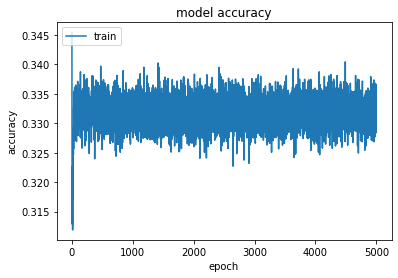

In [319]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(model.history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [322]:
dist_pred = []
dist_lab = []
open_pred = []
open_lab = []
rot_pred = []
rot_lab = []
    
for index in range(1000):
    

    pred = model.predict(np.asarray([batcher.imageoutputs[index]]))[0][0]
    dist_pred.append( pred[0] )
    open_pred.append( pred[1] )
    rot_pred.append( pred[2] )

    lab = batcher.labels[index][0]
    dist_lab.append( lab[0]  )
    open_lab.append( lab[1] )
    rot_lab.append( lab[2] )


plt.plot(dist_pred)
plt.plot(dist_lab)
plt.show()

plt.plot(open_pred)
plt.plot(open_lab)
plt.show()

plt.plot(rot_pred)
plt.plot(rot_lab)
plt.show()
#plt.imshow(batcher.images[index].astype(np.int32))
#plt.show()

ValueError: Error when checking input: expected dense_127_input to have shape (1, 84) but got array with shape (1, 42)

array([3.5e-323, 0.0e+000, 0.0e+000, 0.0e+000, 0.0e+000])